**Google Colab x Kaggle** 
# LANL Earthquake Prediction Training Model

Date: 2022.3.15-2022.04.15


*Mao Zunjie*

*18098531-i011-0019*

Dataset [LANL Earthquake Dataset](https://www.kaggle.com/competitions/LANL-Earthquake-Prediction/data)




# Step 1 - Install & Import Libraries

In [1]:

!pip install kaggle

!pip install numpy

!pip install catboost

#data preprocessing
import pandas as pd
#math operations
import numpy as np
import matplotlib.pyplot as plt
#machine learning
from catboost import CatBoostRegressor,Pool
#data scaling
from sklearn.preprocessing import StandardScaler
#hyperparameter optimization
from sklearn.model_selection import GridSearchCV
#support vector machine model
from sklearn.svm import NuSVR, SVR
#kernel ridge model
from sklearn.kernel_ridge import KernelRidge
#data visualization
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.model_selection import train_test_split

     |████████████████████████████████| 76.1 MB 6.7 MB/s 


# Step 2 - Import Dataset from Kaggle

In [2]:
# Colab's file access
from google.colab import files

#retrieve uploaded file
uploaded = files.upload()

#print results
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 65 bytes


In [3]:

!kaggle competitions list

ref                                                         deadline             category            reward  teamCount  userHasEntered  
----------------------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
mpetitions/contradictory-my-dear-watson                     2030-07-01 23:59:00  Getting Started     Prizes         41           False  
mpetitions/gan-getting-started                              2030-07-01 23:59:00  Getting Started     Prizes        105           False  
mpetitions/store-sales-time-series-forecasting              2030-06-30 23:59:00  Getting Started  Knowledge       1386           False  
mpetitions/tpu-getting-started                              2030-06-03 23:59:00  Getting Started  Knowledge        180           False  
mpetitions/digit-recognizer                                 2030-01-01 00:00:00  Getting Started  Knowledge       2090           False  
mpetitions/titanic                       

In [4]:

!kaggle competitions download -c LANL-Earthquake-Prediction

100% 2.27G/2.27G [00:22<00:00, 80.1MB/s]
100% 2.27G/2.27G [00:22<00:00, 108MB/s] 


In [5]:

!ls
!unzip LANL-Earthquake-Prediction.zip 
!ls

LANL-Earthquake-Prediction.zip	sample_data
Archive:  LANL-Earthquake-Prediction.zip
  inflating: sample_submission.csv   
  inflating: test/seg_00030f.csv     
  inflating: test/seg_0012b5.csv     
  inflating: test/seg_00184e.csv     
  inflating: test/seg_003339.csv     
  inflating: test/seg_0042cc.csv     
  inflating: test/seg_004314.csv     
  inflating: test/seg_004cd2.csv     
  inflating: test/seg_004ee5.csv     
  inflating: test/seg_004f1f.csv     
  inflating: test/seg_00648a.csv     
  inflating: test/seg_006e4a.csv     
  inflating: test/seg_007a37.csv     
  inflating: test/seg_00a37e.csv     
  inflating: test/seg_00be11.csv     
  inflating: test/seg_00c35b.csv     
  inflating: test/seg_00cc91.csv     
  inflating: test/seg_00e5f7.csv     
  inflating: test/seg_00f3b9.csv     
  inflating: test/seg_010eab.csv     
  inflating: test/seg_0125d9.csv     
  inflating: test/seg_0144cb.csv     
  inflating: test/seg_0165c6.csv     
  inflating: test/seg_016913.csv     
  in

# Step 3 - Data Analysis

In [6]:

train = pd.read_csv('train.csv', nrows=100000000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})
submission = pd.read_csv('sample_submission.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

In [7]:
#print first 10 entries
train.head(10)

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691
5,8,1.4691
6,9,1.4691
7,7,1.4691
8,-5,1.4691
9,3,1.4691


In [8]:
for n in range(10):
    print(train.time_to_failure.values[n])

1.4690999832
1.4690999821
1.469099981
1.4690999799
1.4690999788
1.4690999777
1.4690999766
1.4690999755
1.4690999744
1.4690999733


In [9]:
submission.head(10)

,seg_id,time_to_failure
0,seg_00030f,0.0
1,seg_0012b5,0.0
2,seg_00184e,0.0
3,seg_003339,0.0
4,seg_0042cc,0.0
5,seg_004314,0.0
6,seg_004cd2,0.0
7,seg_004ee5,0.0
8,seg_004f1f,0.0
9,seg_00648a,0.0


In [10]:
submission.shape

(2624, 2)

In [11]:
train.isnull().sum()

acoustic_data      0
time_to_failure    0
dtype: int64

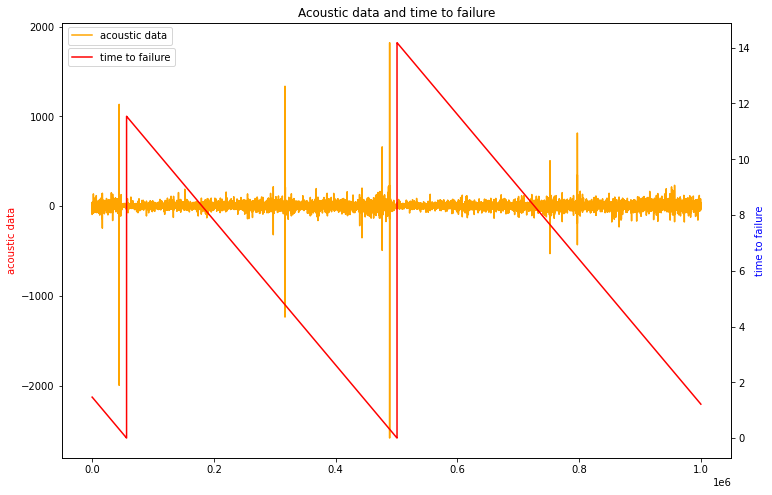

In [12]:

train_ad_sample_df = train['acoustic_data'].values[::100]
train_ttf_sample_df = train['time_to_failure'].values[::100]
                                                      

#function for plotting based on both features
def plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure"):

    fig,ax1=plt.subplots(figsize=(12,8))
    plt.title(title)
    plt.plot(train_ad_sample_df, color='orange')
    ax1.set_ylabel('acoustic data', color='r')
    plt.legend(['acoustic data'], loc=(0.01,0.95))
    ax2 = ax1.twinx()
    plt.plot(train_ttf_sample_df, color='red')
    ax2.set_ylabel('time to failure', color='b')
    plt.legend(['time to failure'], loc=(0.01,0.9))
    plt.grid(False)

plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df)
del train_ad_sample_df
del train_ttf_sample_df


In [13]:
print(os.path.abspath('test'))


/content/test


In [14]:
test_files =os.listdir("/content/test/")
print(test_files[0:4])

['seg_a68ffb.csv', 'seg_0dcc40.csv', 'seg_29d497.csv', 'seg_46dd7c.csv']


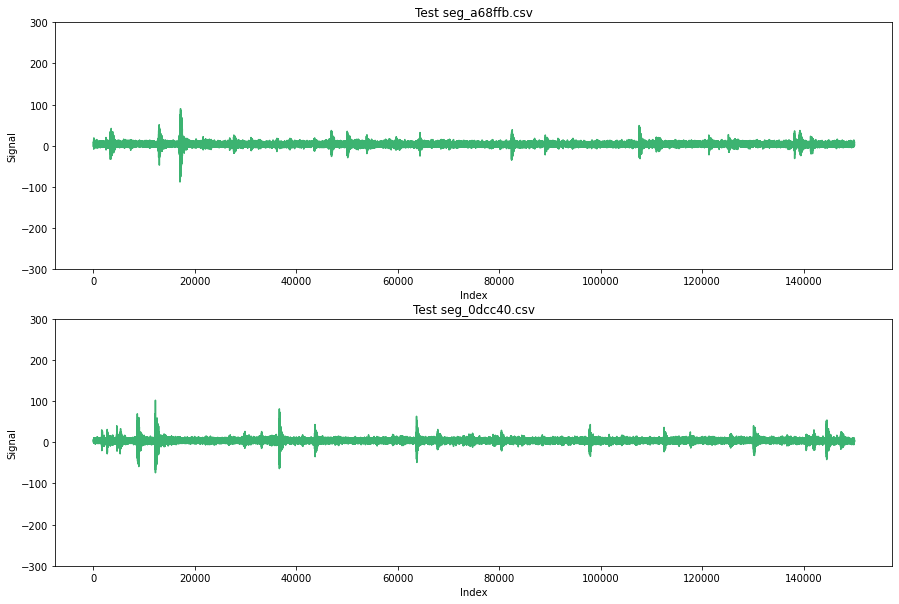

In [15]:
fig, ax = plt.subplots(2,1, figsize=(15,10))
test_path="/content/test/"

for n in range(2):
    seg = pd.read_csv(test_path+test_files[n])
    ax[n].plot(seg.acoustic_data.values, c="mediumseagreen")
    ax[n].set_xlabel("Index")
    ax[n].set_ylabel("Signal")
    ax[n].set_ylim([-300, 300])
    ax[n].set_title("Test {}".format(test_files[n]));

# Step 4 - Feature Engineering

In [16]:
# Step 4 - Feature Engineering and signifiance of these statistical features

#lets create a function to generate some statistical features based on the training data
def gen_features(X):
    strain = []
    strain.append(X.mean())
    strain.append(X.std())
    strain.append(X.min())
    strain.append(X.max())
    strain.append(X.kurtosis())
    strain.append(X.skew())
    strain.append(np.quantile(X,0.01))
    strain.append(np.quantile(X,0.05))
    strain.append(np.quantile(X,0.95))
    strain.append(np.quantile(X,0.99))
    strain.append(np.abs(X).max())
    strain.append(np.abs(X).mean())
    strain.append(np.abs(X).std())
    return pd.Series(strain)



In [19]:
df.iloc[:,1].skew()

0.009113453508960827

In [20]:
df.iloc[:,1].kurt()

-1.211868195140002

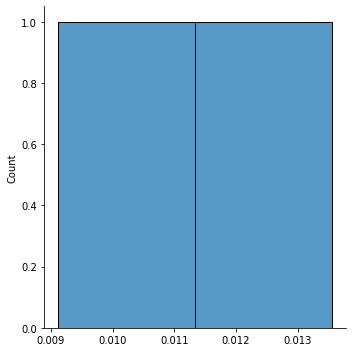

In [21]:
sns.displot(df.skew())

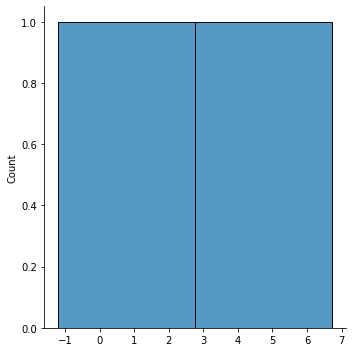

In [22]:
sns.displot(df.kurt())

In [18]:
train = pd.read_csv('train.csv', chunksize=150000, iterator=True, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

X_train = pd.DataFrame()
y_train = pd.Series()
for df in train:
    ch = gen_features(df['acoustic_data'])
    X_train = X_train.append(ch,ignore_index=True)
    y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  after removing the cwd from sys.path.


In [23]:
ch.skew()

0.5050044063296342

In [24]:
ch.kurt()

1.8958486649101371

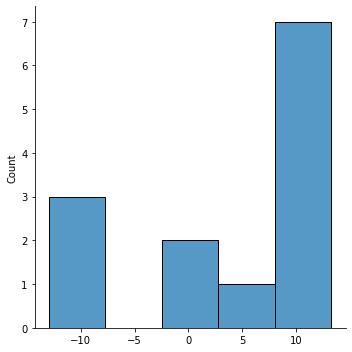

In [25]:
sns.displot(X_train.skew())

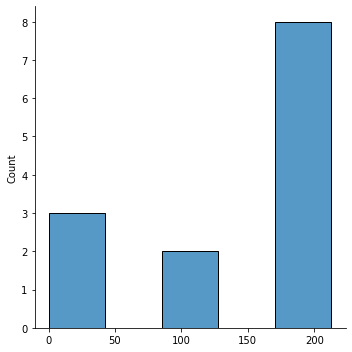

In [26]:
sns.displot(X_train.kurt())

In [27]:
print(X_train.shape)

(4195, 13)


In [28]:
X_train.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12
count,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000
mean,4.519475,6.547788,-149.190942,163.522288,68.297997,0.125830,-11.224603,-2.184779,11.231716,20.321890,170.046246,5.547367,5.750165
std,0.256049,8.503939,265.087984,272.930331,70.532565,0.477901,14.106852,2.346558,2.358067,14.225526,296.887015,1.517038,8.339211
min,3.596313,2.802720,-5515.000000,23.000000,0.648602,-4.091826,-336.000000,-39.000000,9.000000,11.000000,23.000000,4.147707,2.589085
25%,4.349497,4.478637,-154.000000,92.000000,28.090227,-0.040779,-14.000000,-3.000000,10.000000,15.000000,94.000000,5.061843,3.862810
50%,4.522147,5.618798,-111.000000,123.000000,45.816625,0.085620,-10.000000,-2.000000,11.000000,19.000000,127.000000,5.380853,4.781513
75%,4.693350,6.880904,-79.000000,170.000000,78.664202,0.253930,-6.000000,-1.000000,12.000000,23.000000,175.000000,5.748553,5.887947
max,5.391993,153.703569,-15.000000,5444.000000,631.158927,4.219429,-2.000000,0.000000,50.000000,337.000000,5515.000000,32.762073,150.432368


In [29]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,4.884113,5.101106,-98.0,104.0,33.662481,-0.024061,-8.0,-2.0,11.0,18.0,104.0,5.576567,4.333325
1,4.725767,6.588824,-154.0,181.0,98.758517,0.390561,-11.0,-2.0,12.0,21.0,181.0,5.734167,5.732777
2,4.906393,6.967397,-106.0,140.0,33.555211,0.217391,-15.0,-3.0,13.0,26.0,140.0,6.152647,5.895945
3,4.902240,6.922305,-199.0,197.0,116.548172,0.757278,-12.0,-2.0,12.0,22.0,199.0,5.933960,6.061214
4,4.908720,7.301110,-126.0,145.0,52.977905,0.064531,-15.0,-2.0,12.0,26.0,145.0,6.110587,6.329485


In [30]:
y_train.head()
y_train.shape

(4195,)

In [31]:
y_train.head()

0    1.430797
0    1.391499
0    1.353196
0    1.313798
0    1.274400
dtype: float64

In [32]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4195 entries, 0 to 4194
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       4195 non-null   float64
 1   1       4195 non-null   float64
 2   2       4195 non-null   float64
 3   3       4195 non-null   float64
 4   4       4195 non-null   float64
 5   5       4195 non-null   float64
 6   6       4195 non-null   float64
 7   7       4195 non-null   float64
 8   8       4195 non-null   float64
 9   9       4195 non-null   float64
 10  10      4195 non-null   float64
 11  11      4195 non-null   float64
 12  12      4195 non-null   float64
dtypes: float64(13)
memory usage: 426.2 KB


# Step 5 - Implement Catboost Model



In [33]:
#Model-Catboost

train_pool = Pool(X_train, y_train)
X_train, X_validation, y_train, y_validation = train_test_split(df.iloc[:,:-1],df.iloc[:,-1],test_size=0.3 , random_state=1234)
m = CatBoostRegressor(iterations=10000, loss_function='MAE', boosting_type='Ordered')

m.fit(X_train, y_train, silent=True)

m.best_score_

{'learn': {'MAE': 0.0029278506134147275}}

In [43]:
from sklearn import metrics

In [45]:
# Validation
val_predictions = m.predict(X_validation)
print(metrics.mean_absolute_error(y_validation, val_predictions))


0.0029595576081423666


# Step 6 - Implement Support Vector Machine + RBF Kernel 



In [74]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import NuSVR, SVR


scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

parameters = [{'gamma': [0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.15, 0.25],
         'C': [0.1, 0.2, 0.25, 0.5, 1, 1.5, 2, 3 ]}]
             

reg1 = GridSearchCV(SVR(kernel='rbf'), parameters, cv=5, scoring='neg_mean_absolute_error')
reg1.fit(X_train_scaled, y_train.values.flatten())
print("Score:{:.4f}".format(reg1.best_score_))
print(reg1.best_params_)


Score:-0.0030
{'C': 0.1, 'gamma': 0.001}


# Submit


In [ ]:
submission=pd.read_csv('sample_submission.csv',index_col='seg_id')
X_test = pd.DataFrame(columns=X_train.columns, dtype=np.float64, index=submission.index)

    
#... submission code is in kaggle notebook, so I will not list  here. 

